In [ ]:
%pip install yfinance
%pip install pandas
%pip install image
%pip install matplotlib
%pip install numpy
%pip install shap
%pip install tensorflow

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split # s1p1
from sklearn.preprocessing import MinMaxScaler # s1p1
from tensorflow.keras.models import Sequential # s1p2
from tensorflow.keras.layers import LSTM, Dense, Dropout # s1p2
from sklearn.metrics import mean_squared_error, r2_score # s1p3


## Get indicators for given ticker (NOT NEEDED)


In [ ]:
def get_financial_indicators(ticker):
  """
  Extract key financial indicators for a given company ticker using Yahoo Finance API.

  Args:
  ticker (str): Stock ticker symbol of the company (e.g. 'AAPL' for Apple Inc.).

  Returns:
  dict: A dictionary containing the indicators.
  """
  try:
    # fetch company data
    company = yf.Ticker(ticker)

    # extracting associated metrics
    financial_data = {
      'Company Name': company.info.get('shortName', 'N/A'),
      'Sector': company.info.get('sector', 'N/A'),
      'Industry': company.info.get('industry', 'N/A'),
      'Market Cap': company.info.get('marketCap', 'N/A'),
      'EPS (TTM)': company.info.get('trailingEps', 'N/A'),
      'P/E Ratio': company.info.get('trailingPE', 'N/A'),
      'PEG Ratio': company.info.get('pegRatio', 'N/A'),
      'Price-to-Book Ratio': company.info.get('priceToBook', 'N/A'),
      'Profit Margin': company.info.get('profitMargins', 'N/A'),
      'Dividend Yield': company.info.get('dividendYield', 'N/A'),
      '52-Week High': company.info.get('fiftyTwoWeekHigh', 'N/A'),
      '52-Week Low': company.info.get('fiftyTwoWeekLow', 'N/A'),
      'Beta': company.info.get('beta', 'N/A'),
    }
  except Exception as e:
    print(f"Error fetching data for {ticker}: {e}")
    return None

## Display indicators (NOT NEEDED)

In [ ]:
def display_financial_indicators(tickers):
  """
  Display financial indicators for a list of company tickers.

  Args:
  tickers (list): List of stock ticker symbols.

  Returns:
  pd.DataFrame: DataFrame containing the indicators for a given ticker.
  """
  data = []

  for ticker in tickers:
    indicators = get_financial_indicators(ticker)
    if indicators:
      indicators['Ticker'] = ticker
      data.append(indicators)

  #Convert list into df
  return pd.DataFrame(data)

## Strategy #1 Part 1: Preprocessing data
Features:
- Close ✅ (Raw)
- Volume (Raw)
- 50MA ✅, 200MA ✅, RSI ✅, 20EMA ✅ (Technical)
- P/E Ratio, Dividend Yield, Daily Return ✅ (Fundamental)
- Volatility ✅, Momentum (Derived)


In [ ]:
def calc_rsi(stock, window=14):
  delta = stock['Close'].diff(1)
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)

  avg_gain = gain.rolling(window=window).mean()
  avg_loss = loss.rolling(window=window).mean()

  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))

  return rsi

def calc_ema(stock, window=20):
  return stock['Close'].ewm(span=window, adjust=False).mean()

def calc_vwap(stock):
  return (((stock['High'] + stock['Low'] + stock['Close']) / 3) * stock['Volume']).cumsum() / stock['Volume'].cumsum()

# step 1: fetch stock data
ticker = 'MSFT'
start_date = '2020-01-01'
end_date = '2023-01-01'
stock = yf.download(ticker, start=start_date, end=end_date) # yf.download returns OHLCV
stock.columns = stock.columns.get_level_values(0) # remove multi-level column names

# step 2: feature engineering
stock['Daily Return'] = stock['Close'].pct_change()
stock['50MA'] = stock['Close'].rolling(window=50).mean()
stock['200MA'] = stock['Close'].rolling(window=200).mean()
stock['Volatility'] = stock['Daily Return'].rolling(window=10).std()
stock['RSI'] = calc_rsi(stock)
stock['VWAP'] = calc_vwap(stock)
stock['20EMA'] = calc_ema(stock)
stock = stock.dropna()

# step 3; normalize data
features = ['Close','Daily Return', '50MA', '200MA', 'Volatility', 'RSI', 'VWAP', '20EMA']
X = stock[features]
scaler = MinMaxScaler(feature_range=(0, 1))
# X = pd.DataFrame(scaler.fit_transform(X), columns=features)
normalized_data = scaler.fit_transform(X)

# step 4: create sequences
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:i + sequence_length, :]) # captures all the features in length: seq_length
    y.append(data[i + sequence_length, 0]) # captures target: next day's "Close"
  return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(normalized_data, sequence_length)

# step 5: train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



[*********************100%***********************]  1 of 1 completed


## Strategy #1 Part 2: Making LSTM Model


In [ ]:

# step 1: init model
model = Sequential()

# step 2: add LSTM layers
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # regularization

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# step 3: add Dense output layer
model.add(Dense(units=1)) # Predict the next day's "Close" price

# step 4: compile model
model.compile(optimizer='adam',
              loss='mse')

# step 5: model summary
model.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 30, 32)              │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,601 (53.13 KB)

 Trainable params: 13,601 (53.13 KB)

 Non-trainable params: 0 (0.00 B)

## Strategy #1 Part 3: Training LSTM model + making predictions
(Close, Daily Return, 50MA, Volatility, RSI) MSE: 69.40, R-Squared: 0.93

(Close, Daily Return 50MA, 200MA, Volatility, RSI, VWAP, 20EMA) MSE: 53.23, R-Squared: 0.95

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.2302 - val_loss: 0.0264
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0326 - val_loss: 0.0127
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0240 - val_loss: 0.0074
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0153 - val_loss: 0.0056
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0134 - val_loss: 0.0050
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0128 - val_loss: 0.0045
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0123 - val_loss: 0.0045
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0103 - val_loss: 0.0041
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0110 - val_loss: 0.0042
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0111 - val_loss: 0.0039
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0109 - val_loss: 0.0042
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.

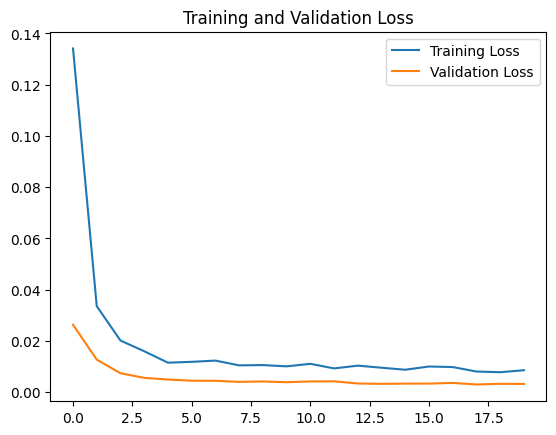

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


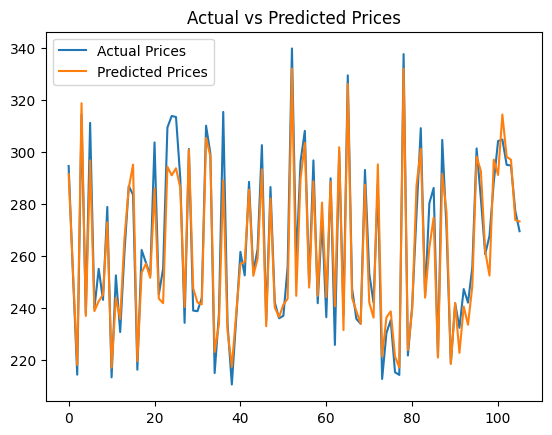

Mean Squared Error: 64.34, R-squared: 0.94


In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20, batch_size=32, verbose=1)

# plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

predicted_prices = model.predict(X_test)

# temp array, same shape as original dataset
temp = np.zeros((predicted_prices.shape[0], len(features)))
temp[:,0] = predicted_prices[:,0] # predicted prices go in first column
predicted_prices_actual = scaler.inverse_transform(temp)[:,0] # take the first column and do inverse normalization to get that actual predicted prices

# doing the same for y_test
temp = np.zeros((y_test.shape[0], len(features)))
temp[:, 0] = y_test[:, 0] if y_test.ndim > 1 else y_test # Place the values of y_test in the first column
y_test_actual = scaler.inverse_transform(temp)[:, 0] # Perform inverse normalization to get the actual values



plt.plot(y_test_actual, label='Actual Prices')
plt.plot(predicted_prices_actual, label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

mse = mean_squared_error(y_test_actual, predicted_prices_actual)
r2 = r2_score(y_test_actual, predicted_prices_actual)
print(f'Mean Squared Error: {mse:.2f}, R-squared: {r2:.2f}')

## Strategy #1 Part 4: Strategy testing?



   Predcited Trend  Signal
0       -39.818926       0
1       -40.760221       0
2       109.813596       1
3       -89.688164       0
4        65.865556       1


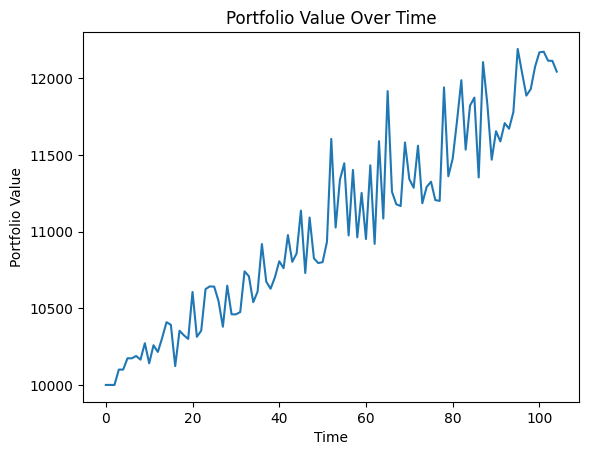

In [ ]:
predicted_trends = np.diff(predicted_prices_actual)

signals = [1 if trend > 0 else 0 for trend in predicted_trends]

results_df = pd.DataFrame({
    'Predcited Trend': predicted_trends,
    'Signal': signals
})

print(results_df.head())

capital = 10000
positions = 0
portfolio = []

for i in range(len(signals)):
  if signals[i] == 1 and capital > y_test_actual[i]:
    positions += 1
    capital -= y_test_actual[i]
  elif signals[i] == 0 and positions > 0:
    positions -= 1
    capital += y_test_actual[i]

  total_value = capital + positions * y_test_actual[i]
  portfolio.append(total_value)

plt.plot(portfolio, label='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.show()